In [322]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [323]:
df = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\bank churn\resources\analytical_base_table.csv")  # replace with actual data path
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Define columns
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']


In [324]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), scale_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])


In [325]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', max_iter=500))
])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'model__C': 1, 'model__class_weight': None, 'model__penalty': 'l2'}


In [337]:
grid.best_score_

0.8311572493422974

In [326]:
probs_val = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div-by-zero
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal Threshold (F1 max): {best_thresh:.4f}")


Optimal Threshold (F1 max): 0.5821


In [327]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test >= best_thresh).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print(classification_report(y_test, y_pred_test))


ROC-AUC on Test: 0.8382
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1593
           1       0.51      0.68      0.58       407

    accuracy                           0.80      2000
   macro avg       0.71      0.76      0.73      2000
weighted avg       0.83      0.80      0.81      2000



array([0.20375   , 0.20387742, 0.20400501, ..., 1.        , 1.        ,
       1.        ])

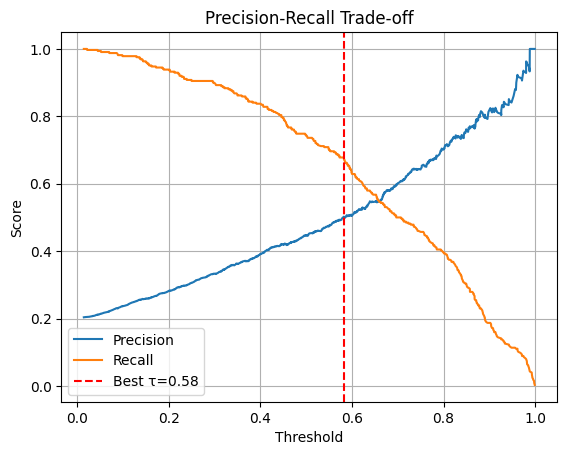

In [328]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Best τ={best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Trade-off")
plt.legend()
plt.grid(True)
plt.show()


In [332]:
probs_test

array([0.14649897, 0.25851667, 0.14020911, ..., 0.9173419 , 0.16541817,
       0.40734968])

In [334]:
from joblib import dump

model_package = {
    'model':best_model,
    'threshold':best_thresh
}
dump(model_package,'../models/log_model.pkl')

['../models/log_model.pkl']

In [339]:
def lr():
    return best_thresh